# Gene exploration for mQTLs
1. Checking overlap in genes for sex-biased and marginal mQTLs in the delahaye data
2. Checking relative enrichment of these genes in housekeeping regions as defined from the HRT ATLAS human housekeeping genes set

In [1]:
library(data.table)
library(tidyverse)
library(UpSetR)
library(eulerr)
sex_specific <- fread("../data/sex_annotated_hits.txt.gz")
marginal <- fread("../data/marginal_annotated_hits.txt.gz")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



[1] 65

[1] 553

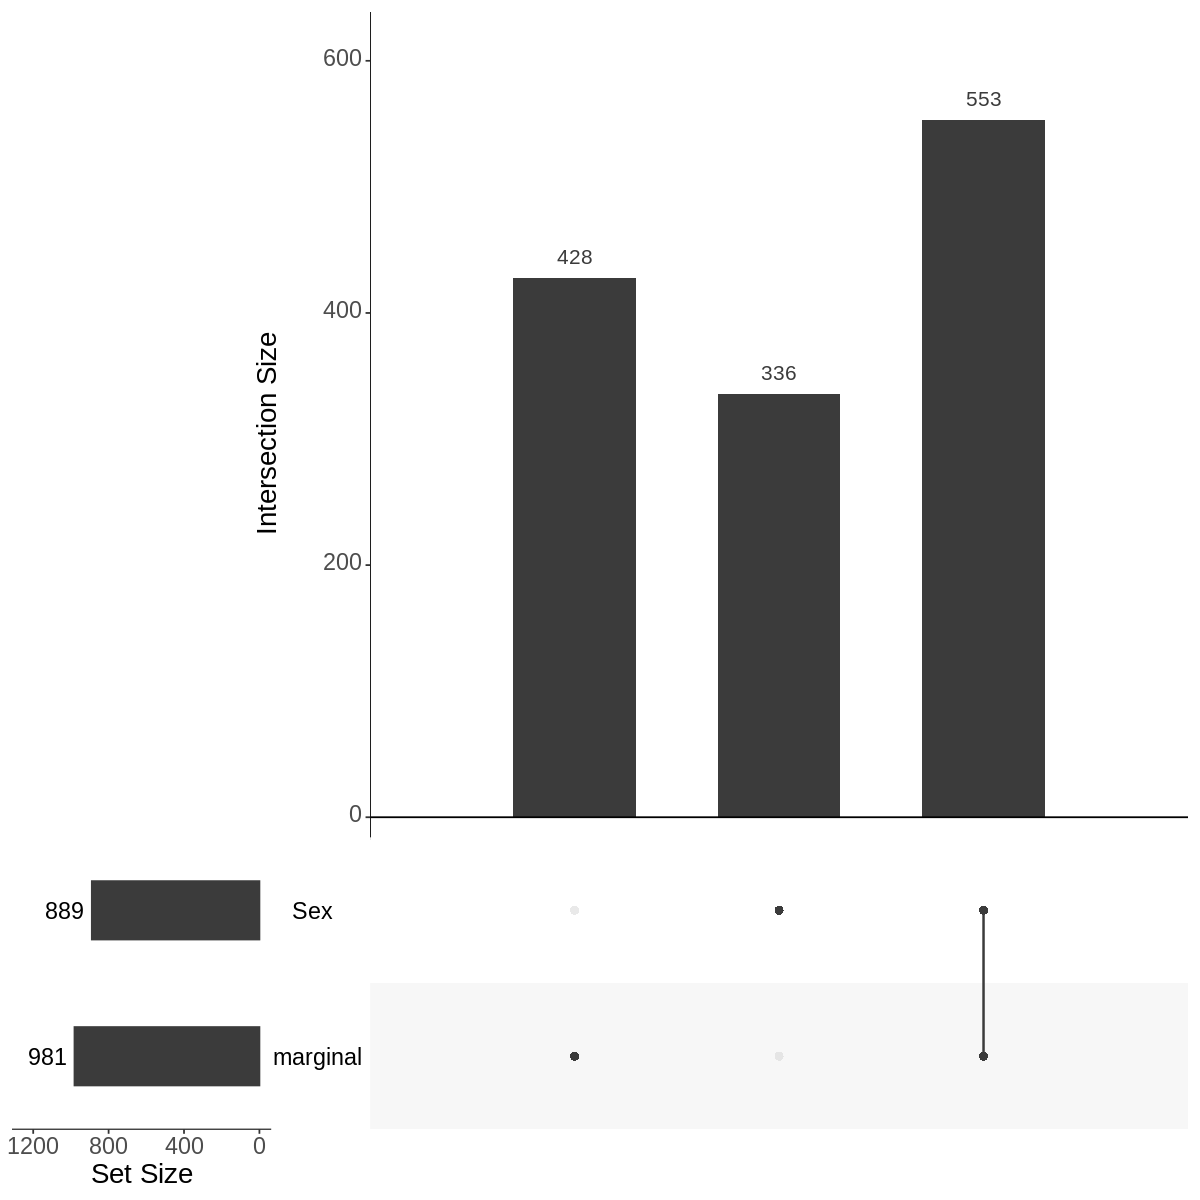

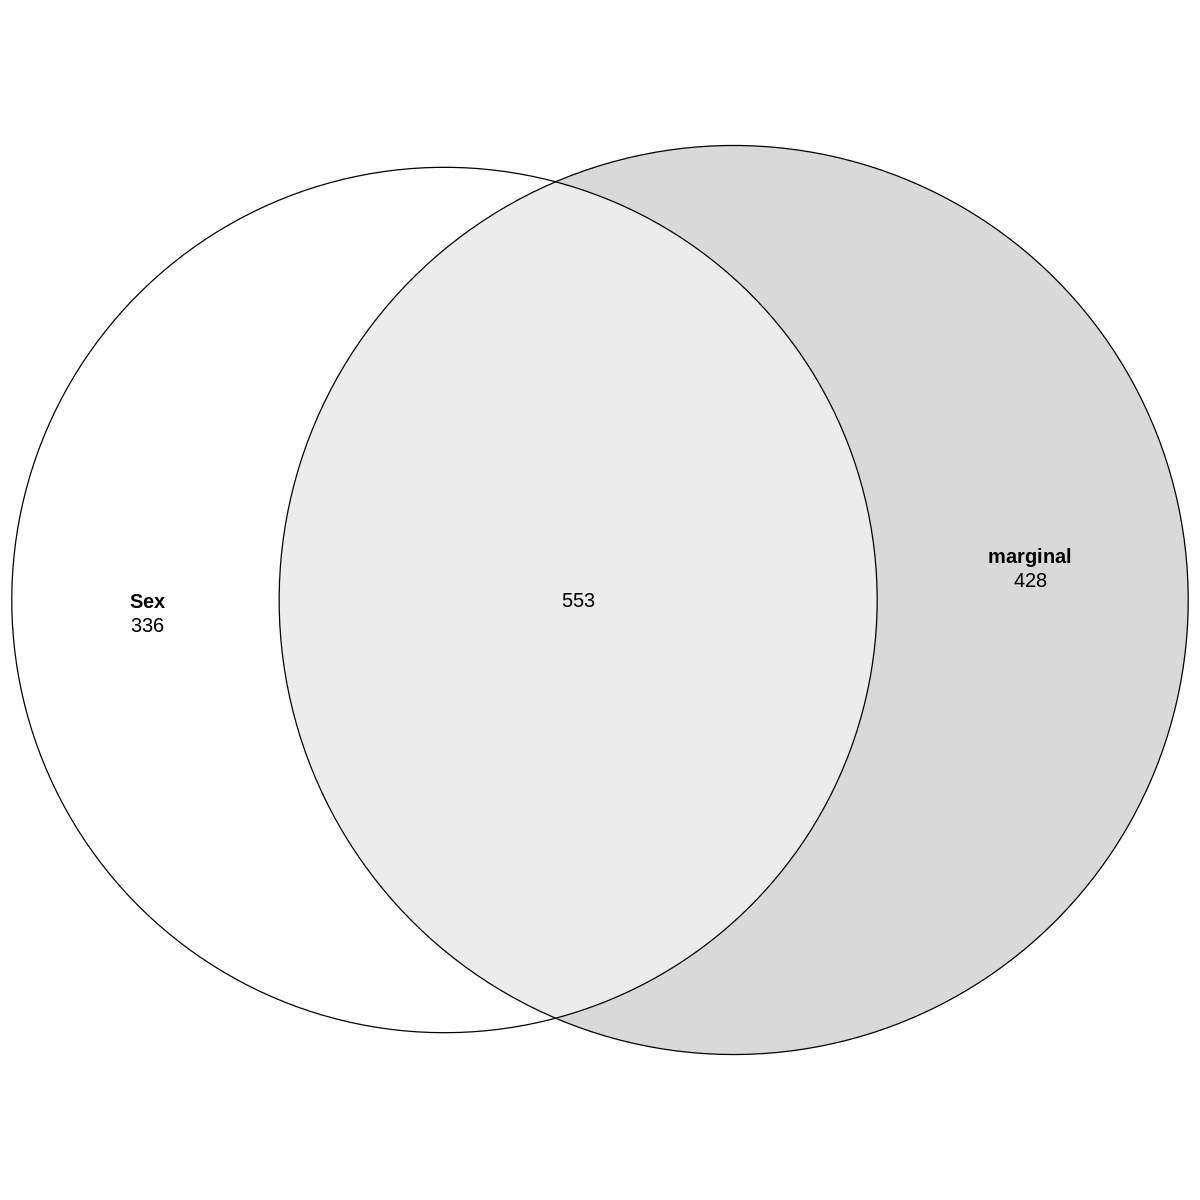

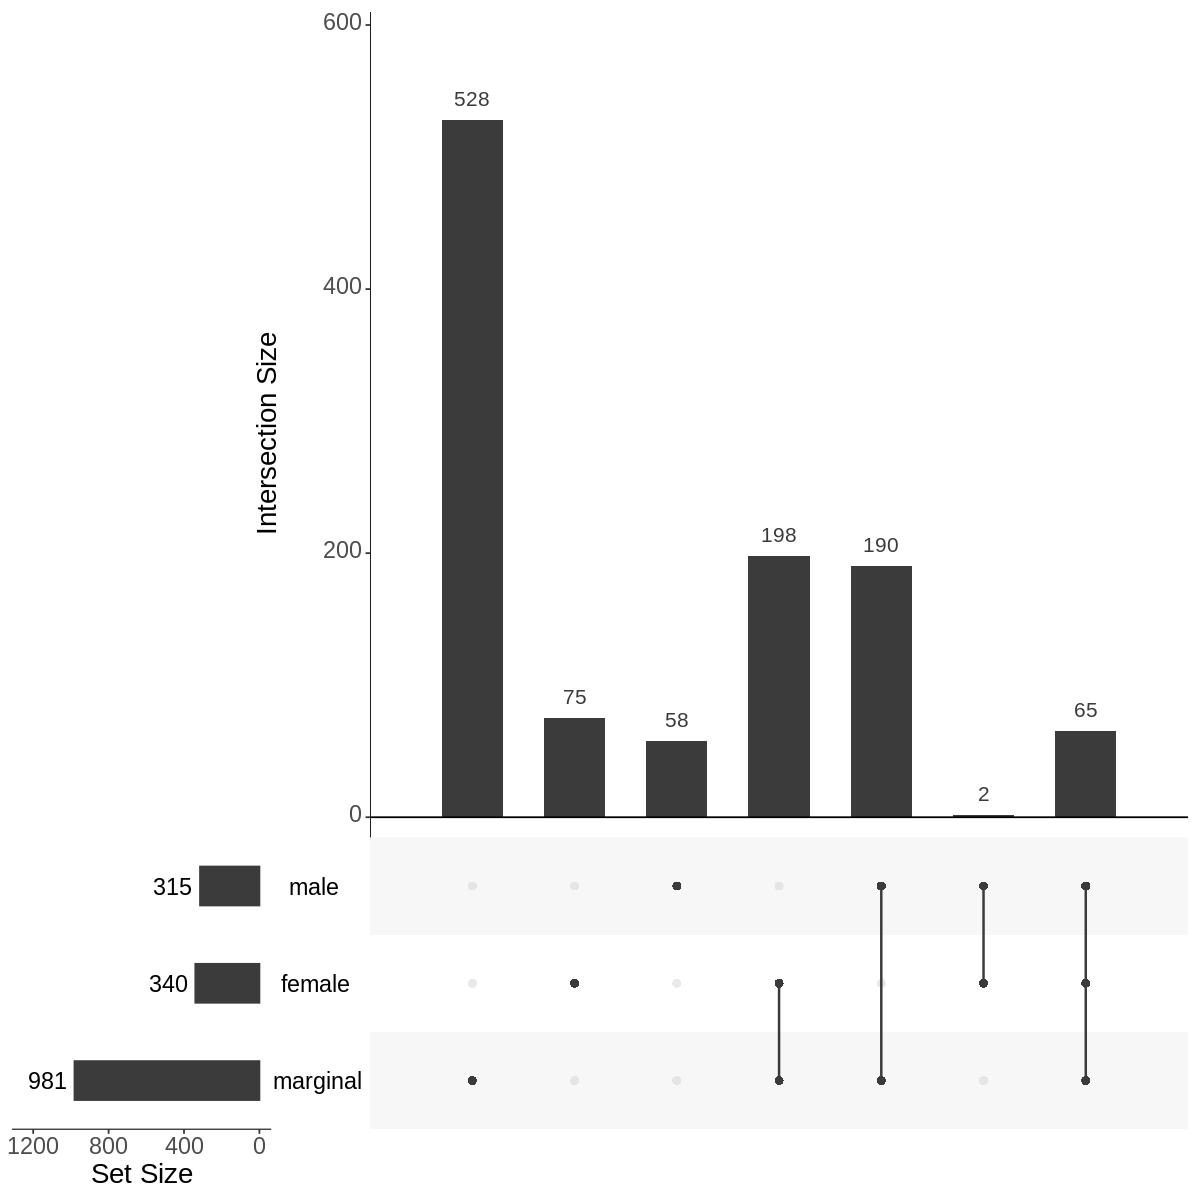

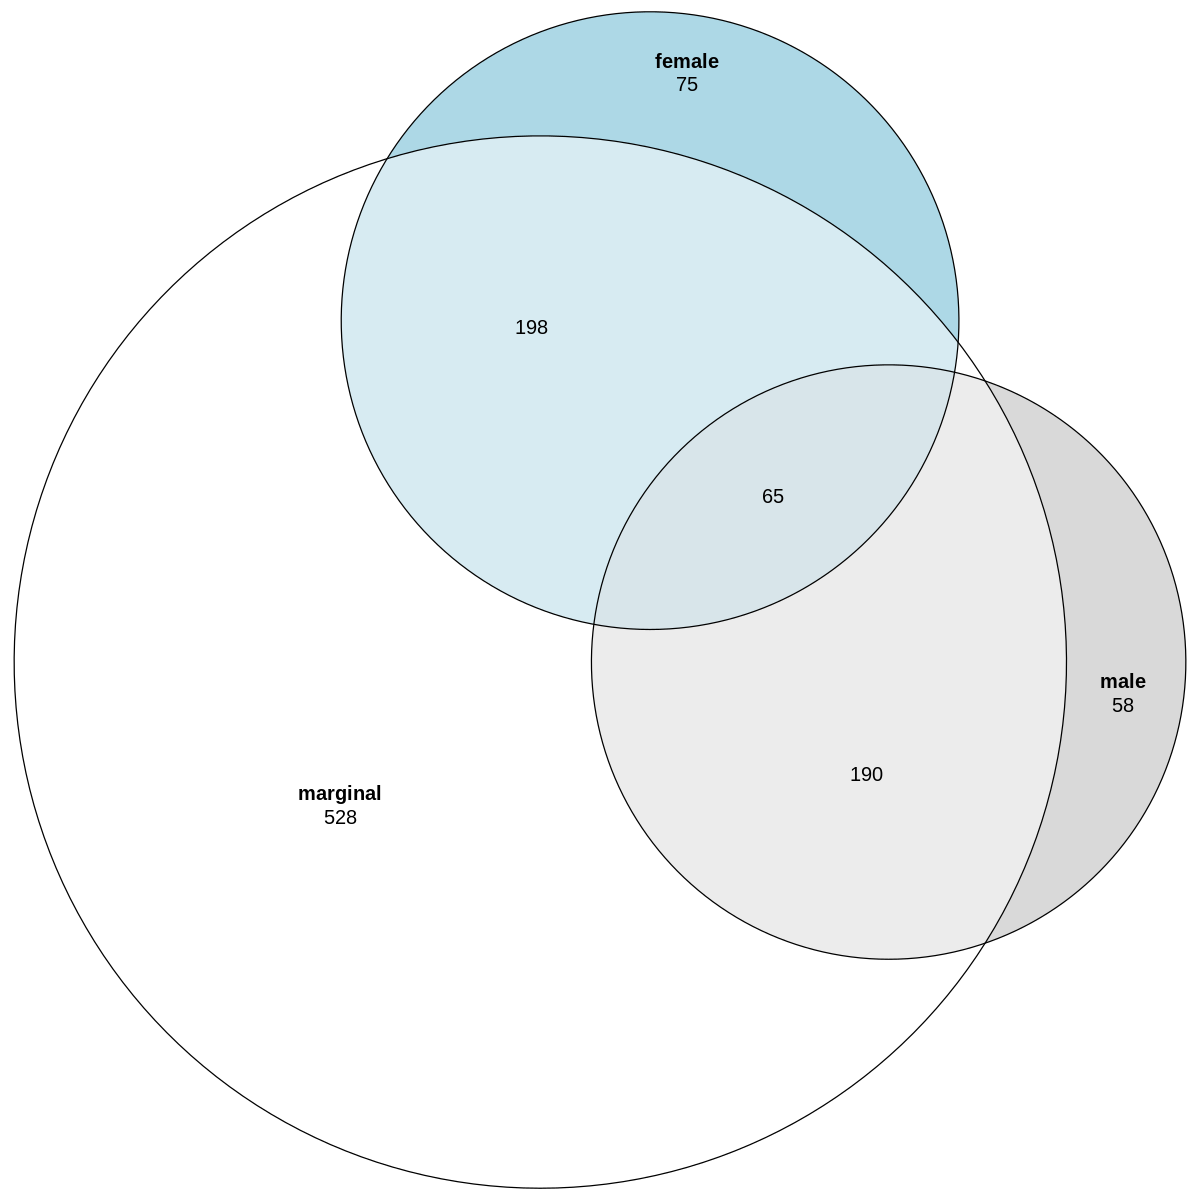

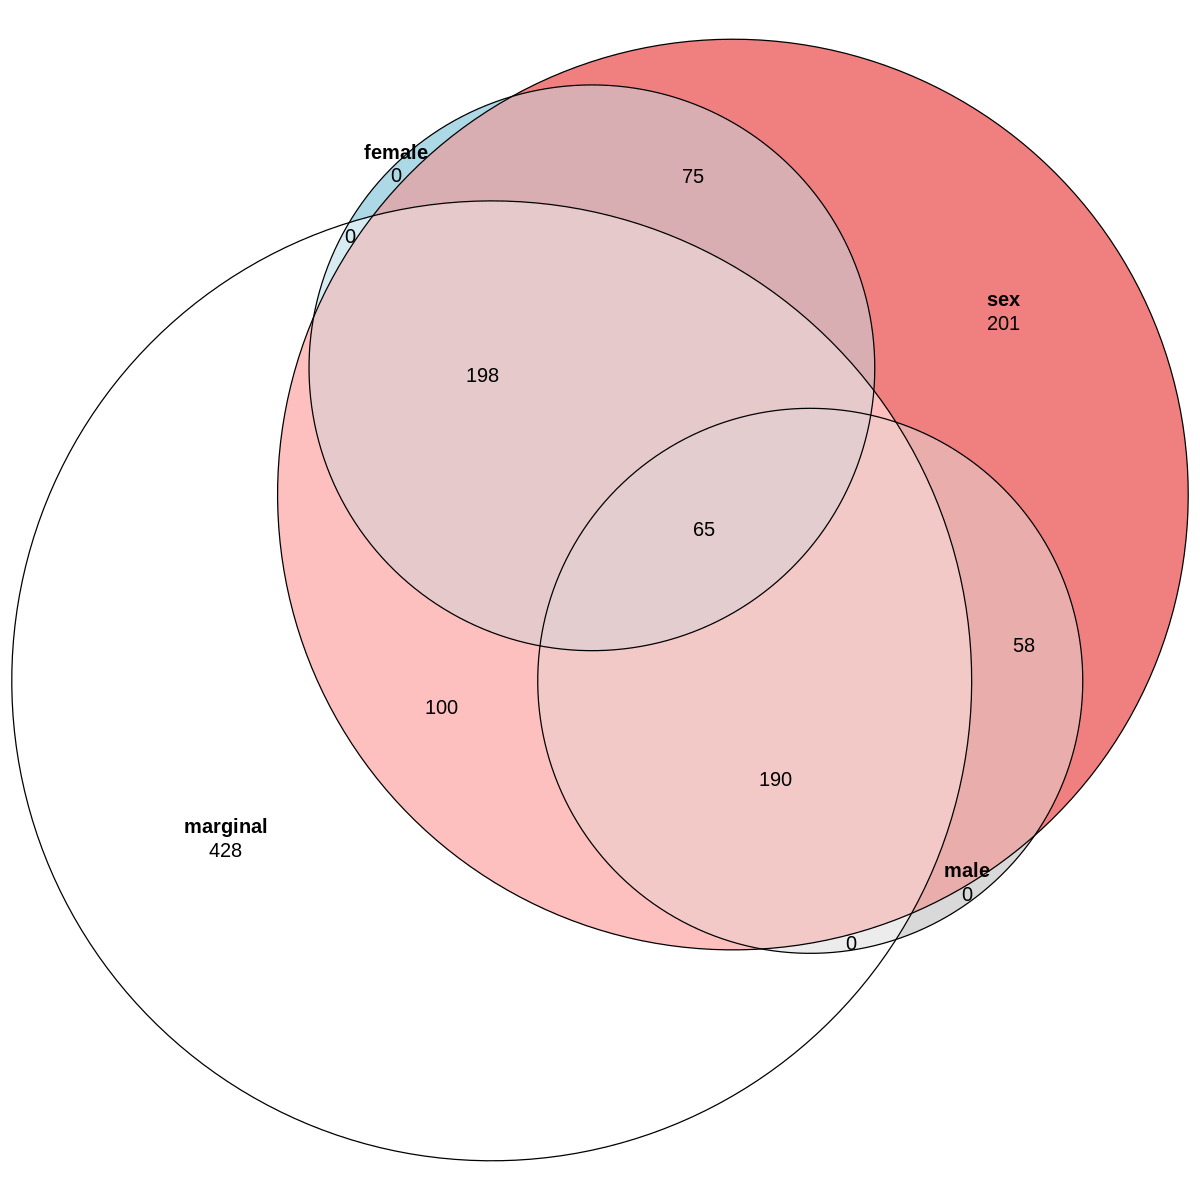

In [2]:
options(repr.plot.width=10, repr.plot.height=10)
sex_genes <- gsub(";.*","",sex_specific$UCSC_RefGene_Name)
male_genes <- gsub(";.*","",sex_specific[res_m < max(`p-value`)]$UCSC_RefGene_Name)
female_genes <- gsub(";.*","",sex_specific[res_f < max(`p-value`)]$UCSC_RefGene_Name)
marginal_genes <- gsub(";.*","",marginal$UCSC_RefGene_Name)

sex_genes <- unique(sex_genes[sex_genes != ""])
female_genes <-  unique(female_genes[female_genes != ""])
male_genes <-  unique(male_genes[male_genes != ""])
marginal_genes <-  unique(marginal_genes[marginal_genes != ""])


length(Reduce(function(a,b) intersect(a,b), list(sex_genes,male_genes,female_genes,marginal_genes)))
length(intersect(sex_genes,marginal_genes))
upset_data <- fromList(list(Sex=sex_genes, marginal=marginal_genes))    
upset(upset_data, group.by=c("degree"), empty.intersections="on", set_size.show = TRUE,text.scale = 2,set_size.scale_max = 1250)
plot(euler(upset_data),quantities=TRUE)

upset_data_sex <- fromList(list(marginal= marginal_genes,male=male_genes,female=female_genes))
upset(upset_data_sex, group.by=c('degree'), empty.intersections="on", set_size.show = TRUE,text.scale=2,set_size.scale_max = 1250)
plot(euler(upset_data_sex),quantities=TRUE)

upset_data_all <- fromList(list(marginal= marginal_genes,male=male_genes,female=female_genes,sex=sex_genes))
plot(euler(upset_data_all),quantities=TRUE)

## Housekeeping genes in humans

In [46]:
hk_genes <- unique(fread("../../Housekeeping_GenesHuman.csv")$Gene.name)
array_genes <- gsub(";.*","",fread("../../450k_annotation.csv")$UCSC_RefGene_Name)
array_genes <- unique(array_genes[array_genes != ""])
hk_genes <- hk_genes[hk_genes %in% array_genes]

GeneSet,OR,low,high,P
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Sex,1.198253,0.9560461,1.488395,0.10067921
Male,1.009747,0.6668823,1.478707,0.92270479
Female,1.397364,0.9868708,1.936394,0.04889947
Marginal,1.290812,1.0470229,1.579625,0.01597987


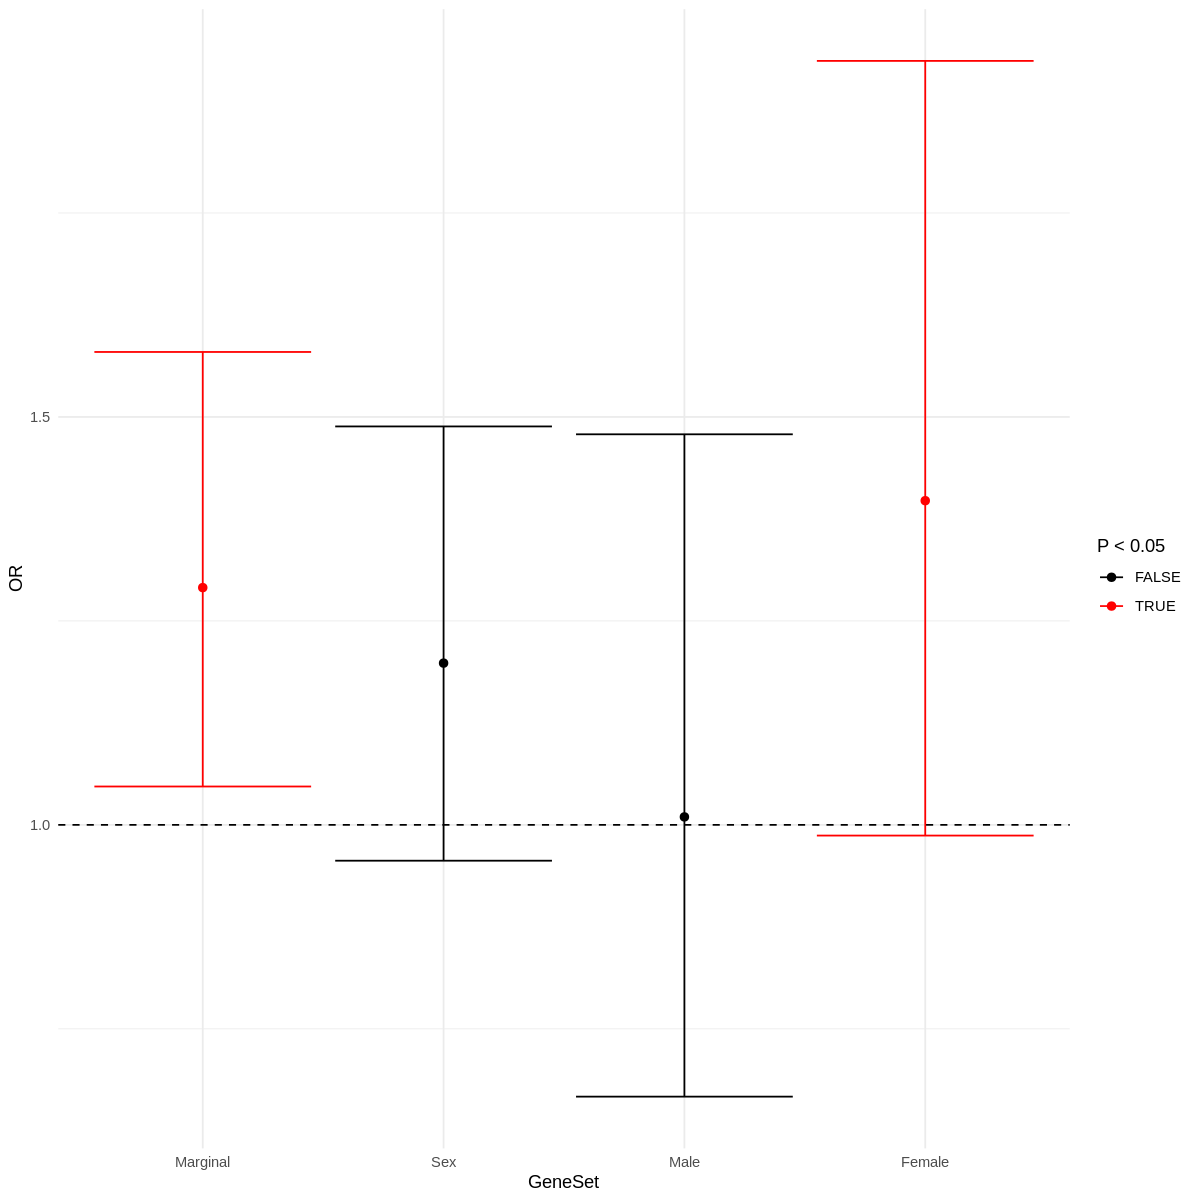

In [67]:
white <- length(hk_genes)
black <- sum(!array_genes %in% hk_genes)

fisher_mat <- function(set1,set2,background){
    notset1 <- background[!background %in% set1]
    notset2 <- background[!background %in% set2]    
    res <- matrix(
        c(
            length(intersect(set1,set2)),
            length(intersect(notset1,set2)),
            length(intersect(set1,notset2)),
            length(intersect(notset1,notset2))
        ),
        byrow=T,
        nrow = 2
    )
    return(res)
}
hk_fisher_res <- function(set){
    res <- fisher.test(fisher_mat(set,hk_genes,array_genes))
    data.table(
        OR = res$estimate,
        low = res$conf.int[1],
        high = res$conf.int[2],
        P = res$p.value
    )
}
res <- rbindlist(lapply(list(Sex=sex_genes,Male=male_genes,Female=female_genes,Marginal=marginal_genes),hk_fisher_res),idcol = 'GeneSet')
res$GeneSet <- factor(res$GeneSet, levels = c("Marginal","Sex","Male","Female"))
ggplot(res,aes(GeneSet,OR,ymin=low,ymax=high,color=P < 0.05)) + geom_point(size=2) + geom_errorbar(size=0.5) + geom_hline(yintercept = 1,linetype='dashed') + scale_color_manual(values=c("black", "red")) + theme_minimal()
res


In [45]:
print(all(sex_genes %in% array_genes))
print(all(hk_genes %in% array_genes))
sum(array_genes %in% hk_genes)
length(hk_genes)
length(unique(hk_genes))

[1] TRUE
[1] TRUE


[1] 1947

[1] 2551

[1] 1947